# MESA Ecospatial Tutorials 

In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.figure import figaspect

import os
os.sys.path.append('../../../')
from mesa import ecospatial as eco

/opt/miniconda3/envs/mesa/lib/python3.11/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/opt/miniconda3/envs/mesa/lib/python3.11/site-packages/spaghetti/network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


In [2]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['svg.fonttype'] = 'none'  # To keep text as text in SVGs

## Read Data

In [3]:
adata = ad.read_h5ad('/Users/Emrys/Dropbox/spatial_augmentation/data/codex_mouse_spleen/codex_mouse_spleen.h5ad')
adata.obsm['spatial'] = adata.obsm['spatial']/1000 # Convert units to microns

## Customise color palette 

In [4]:
from matplotlib import colors as mcolors
from matplotlib import colormaps

In [5]:
cell_names = sorted(adata.obs['cell_type'].unique().tolist())

In [6]:
tab10 = colormaps['tab10']
tab20b = colormaps['tab20b']
tab20c = colormaps['tab20c']

# Extract specific colors by indexing into the colormap (values from 0 to 1)
# From tab20b: indices 8 to 19
colors_from_tab20b = [tab20b(i) for i in range(8, 20)] + [tab20b(0),tab20b(4),tab20b(3)]
# From tab20c: indices 0-3, 8-11, and 16-19
colors_from_tab20c = [tab20c(i) for i in range(4)] + [tab20c(i) for i in range(8, 12)] + [tab20c(i) for i in range(16, 20)]


# Combine the colors into a custom palette
custom_palette = colors_from_tab20c + colors_from_tab20b

colors_hex = [mcolors.rgb2hex(color) for color in custom_palette]
color_dict = dict(zip(cell_names, colors_hex))
color_dict['CD4(+) T cells'] = mcolors.rgb2hex(tab10(1))
color_dict['CD8(+) T cells'] = '#31a354'
color_dict['CD106(+)CD16/32(-)Ly6C(+)CD31(+)']= '#e7cb94'
color_dict['F4/80(+) mphs'] = mcolors.rgb2hex(tab20c(12))
color_dict['FDCs'] = mcolors.rgb2hex(tab10(3))
color_dict['CD4(+)MHCII(+)'] = '#637939'
color_dict['CD106(-)CD16/32(-)Ly6C(+)CD31(+) stroma'] = mcolors.rgb2hex(tab10(9))
color_dict['noid'] = '#8c6d31'

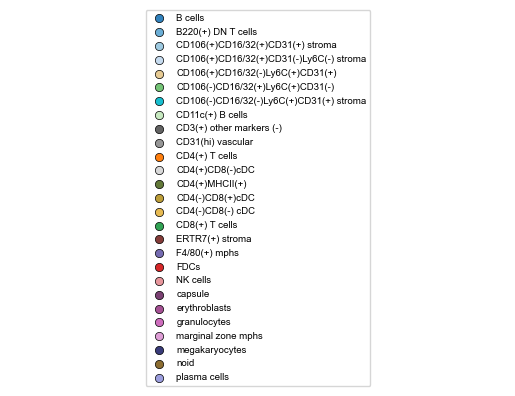

In [7]:
fig, ax = plt.subplots()

for label, color in color_dict.items():
    ax.scatter([], [], c=color, label=label, marker='o',edgecolors='black', linewidths=0.5)

ax.legend(loc='center', ncol=1, fontsize='x-small')
ax.axis('off')
plt.show()

## Perform Ecospatial Analysis on one sample

In [8]:
# Define sample 
sample_id = 'MRL-8'

# Generate Quardrats
patches_coordinates = eco.generate_patches(spatial_data=adata,
                                           library_key='sample',
                                           library_id=sample_id,
                                           scaling_factor=64.,
                                           spatial_key='spatial')

In [9]:
# Calculate MDI
## Define the sequence of scales
scales = [1., 2., 4., 8., 16., 32., 64.]

df_results = eco.calculate_MDI(spatial_data=adata,
                               scales=scales,
                               library_key='sample',
                               library_id=[sample_id],
                               spatial_key='spatial',
                               cluster_key='cell_type',
                               random_patch=False,
                               plotfigs=False,
                               savefigs=False,
                               patch_kwargs={'random_seed': None, 'min_points':2},
                               other_kwargs={'metric': 'Shannon Diversity'})

Processing region: MRL-8 at scale 1.0
0.000 per cent patches are empty
MRL-8 at scale 1.0 has 0 patches with zero diveristy
MRL-8 at scale 1.0 diversity is 3.4656779602794114
Processing region: MRL-8 at scale 2.0
0.000 per cent patches are empty
MRL-8 at scale 2.0 has 0 patches with zero diveristy
MRL-8 at scale 2.0 diversity is 3.292377010141359
Processing region: MRL-8 at scale 4.0
0.000 per cent patches are empty
MRL-8 at scale 4.0 has 0 patches with zero diveristy
MRL-8 at scale 4.0 diversity is 3.0901648127096593
Processing region: MRL-8 at scale 8.0
0.000 per cent patches are empty
MRL-8 at scale 8.0 has 0 patches with zero diveristy
MRL-8 at scale 8.0 diversity is 2.8661607204492103
Processing region: MRL-8 at scale 16.0
0.000 per cent patches are empty
MRL-8 at scale 16.0 has 0 patches with zero diveristy
MRL-8 at scale 16.0 diversity is 2.631288636532884
Processing region: MRL-8 at scale 32.0
0.000 per cent patches are empty
MRL-8 at scale 32.0 has 0 patches with zero diverist

In [10]:
print(f"MDI: {df_results.loc[sample_id].values[0]:.3f}")

MDI: 3.466


0.098 per cent patches are empty


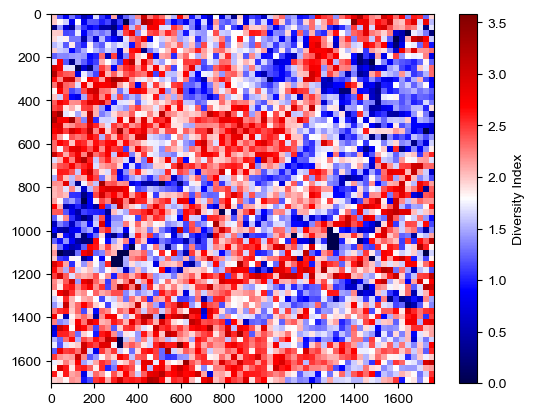

In [11]:
# Caculate Shannon Diversity Index for each quadrat
patch_indices, patches_comp = eco.calculate_diversity_index(spatial_data=adata, 
                                                            library_key='sample', 
                                                            library_id=sample_id, 
                                                            spatial_key='spatial', 
                                                            patches=patches_coordinates, 
                                                            cluster_key='cell_type', 
                                                            metric='Shannon Diversity', return_comp=True)


# Visualize the diversity indices of quadrats
grid, heatmap_fig = eco.diversity_heatmap(spatial_data=adata,
                                          library_key='sample', 
                                          library_id=sample_id,
                                          spatial_key='spatial',
                                          patches=patches_coordinates, 
                                          heterogeneity_indices=patch_indices,
                                          tissue_only=False,
                                          plot=True,
                                          return_fig=True)

In [12]:
# Calculate GDI by applying global moran's I on the Diversity Heatmap
GDI, p_sim = eco.global_spatial_stats(grid, mode='MoranI', tissue_only=False, plot_weights=False)
print(f"GDI: {GDI:.3f}, p-value: {p_sim:.3f}")

GDI: 0.379, p-value: 0.001


Using MoranI


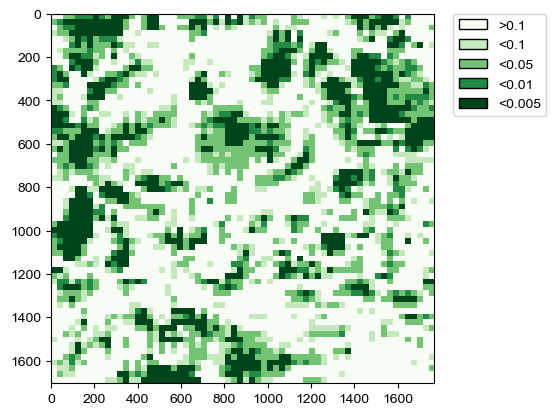

In [13]:
_, _, lisa = eco.local_spatial_stats(grid=grid, 
                                     mode='MoranI', 
                                     tissue_only=False, 
                                     p_value=0.01, 
                                     seed=42, 
                                     plot_weights=False, 
                                     return_stats=True)

heatmap_fig = eco.signif_heatmap(spatial_data=adata,
                                 library_key='sample', 
                                 library_id=sample_id,
                                 spatial_key='spatial',
                                 patches=patches_coordinates, 
                                 heterogeneity_indices=pd.Series(lisa.p_sim),
                                 tissue_only=False,
                                 plot=True,
                                 discrete=True,
                                 return_fig=True)

In [14]:
# Calculate LDI and find hot/coldspots by applying local moran's I on the Diversity Heatmap
hotspots, coldspots = eco.local_spatial_stats(grid, mode='MoranI', p_value=0.01, tissue_only=False)

Using MoranI


width: 1768.140, height: 1704.784


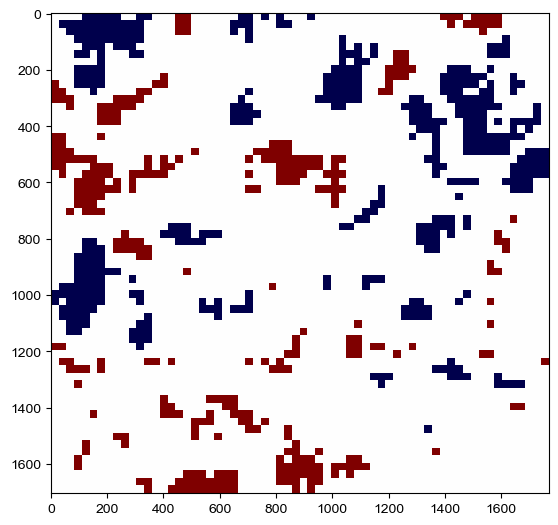

In [15]:
# Visualise hot/coldspot 
combined_spots = (hotspots * 1) + (coldspots * -1)
seismic = plt.cm.seismic
colors = [seismic(0), "white", seismic(0.999)]
cmap = mcolors.LinearSegmentedColormap.from_list("custom_map", colors)

spatial_value = adata[adata.obs['sample']==sample_id].obsm['spatial']
min_x, min_y = spatial_value.min(axis=0)[0], spatial_value.min(axis=0)[1]
max_x, max_y = spatial_value.max(axis=0)[0], spatial_value.max(axis=0)[1]
width = max_x - min_x
height = max_y - min_y
print(f"width: {width:.3f}, height: {height:.3f}")
w, h = figaspect(height/width)

spot_fig = plt.figure(figsize=(w, h))
ax = spot_fig.add_axes([0, 0, 1, 1])

# Create a 2D grid
grid = np.zeros((int(max_y - min_y + 1), int(max_x - min_x + 1)))

# Fill the grid with heterogeneity indices
for patch, diversity_index in enumerate(combined_spots.flatten()):
    x0, y0, x1, y1 = patches_coordinates[patch]
    grid[int(y0-min_y):int(y1-min_y+1), int(x0-min_x):int(x1-min_x+1)] = diversity_index

# Plot the heatmap
ax.imshow(grid, cmap=cmap, interpolation='none', vmin=-1, vmax=1)

In [16]:
# Calculate DPI for hotspots
Hot = True 
proximity_I = eco.calculate_DPI(spatial_data=adata, 
                                scale=64.0, 
                                library_key='sample',
                                library_id=[sample_id], 
                                spatial_key='spatial',
                                cluster_key='cell_type',
                                hotspot=Hot,
                                mode='MoranI',
                                p_value=0.01,
                                metric='Shannon Diversity')
print(f"DPI: {proximity_I.loc[sample_id,'DPI']:.3f}")

Processing region: MRL-8 at scale 64.0
0.098 per cent patches are empty
Using MoranI
Region MRL-8 contains 331 diversity hotspots
61 islands identified
DPI: 183.256


In [17]:
# Visualise Islands composition and similarity
from scipy.spatial.distance import pdist, squareform
labelled_hot, num_hot_islands = eco._utils._label_islands(hotspots, rook=True)
labelled_cold, num_cold_islands = eco._utils._label_islands(coldspots, rook=True)
if Hot:
    print(f"Aggregating hot islands composition")
    filtered_patches_coordinates = [patch for patch, is_hotspot in zip(patches_coordinates, hotspots.flatten()) if is_hotspot]
    filtered_patches_comp = [patch for patch, is_hotspot in zip(patches_comp, hotspots.flatten()) if is_hotspot]
    island_comp = eco._utils.aggregate_spot_compositions(labelled_hot, patches_comp)
else:
    print(f"Aggregating cold islands composition")
    filtered_patches_coordinates = [patch for patch, is_coldspot in zip(patches_coordinates, coldspots.flatten()) if is_coldspot]
    filtered_patches_comp = [patch for patch, is_coldspot in zip(patches_comp, coldspots.flatten()) if is_coldspot]
    island_comp = eco._utils.aggregate_spot_compositions(labelled_cold, patches_comp)
island_comp.head()

Aggregating hot islands composition


cell_type,B cells,B220(+) DN T cells,CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma,CD106(+)CD16/32(-)Ly6C(+)CD31(+),CD106(-)CD16/32(-)Ly6C(+)CD31(+) stroma,CD31(hi) vascular,CD4(+) T cells,CD4(+)CD8(-)cDC,CD4(+)MHCII(+),CD4(-)CD8(+)cDC,CD4(-)CD8(-) cDC,CD8(+) T cells,ERTR7(+) stroma,F4/80(+) mphs,erythroblasts,plasma cells
Island_1,16.0,4.0,18.0,5.0,1.0,4.0,11.0,23.0,2.0,2.0,5.0,3.0,15.0,3.0,12.0,9.0
Island_2,2.0,NaN,20.0,NaN,NaN,NaN,11.0,6.0,NaN,4.0,2.0,3.0,NaN,5.0,14.0,3.0
Island_3,6.0,11.0,29.0,NaN,NaN,NaN,49.0,20.0,1.0,19.0,5.0,20.0,1.0,4.0,7.0,13.0
Island_4,28.0,6.0,7.0,15.0,NaN,NaN,23.0,3.0,NaN,4.0,1.0,17.0,4.0,12.0,46.0,NaN
Island_5,18.0,5.0,NaN,NaN,NaN,NaN,3.0,4.0,NaN,NaN,1.0,5.0,1.0,NaN,7.0,NaN


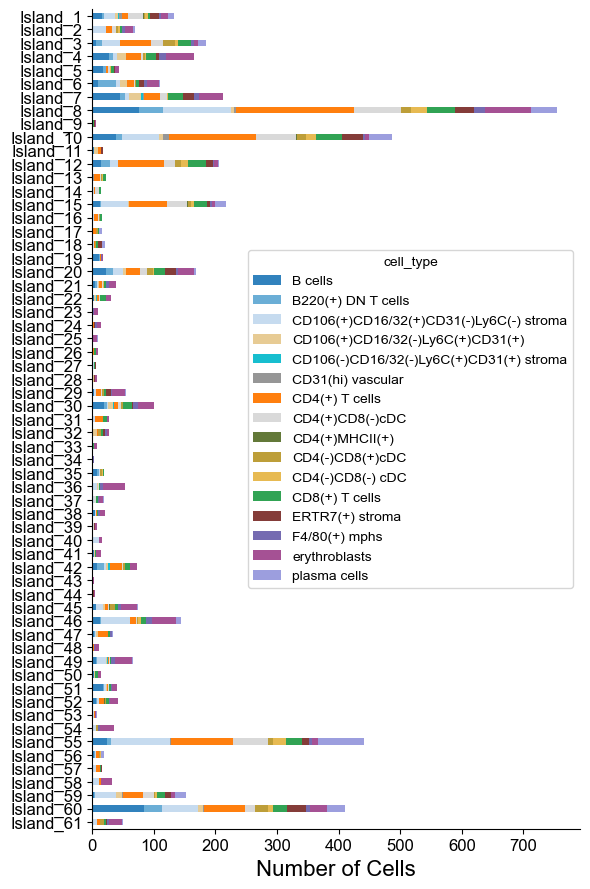

In [18]:
colors = [color_dict[col] for col in island_comp.columns]
ax = island_comp.plot(kind='barh', stacked=True, color=colors, figsize=(6,9))

# Set plot title, axis labels, and legend
plt.title('', fontsize=16)
plt.xlabel('Number of Cells', fontsize=16)
plt.ylabel('')
plt.xticks(rotation=0, fontsize=12)
plt.yticks(rotation=0, fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.invert_yaxis()

plt.tight_layout()
plt.show()

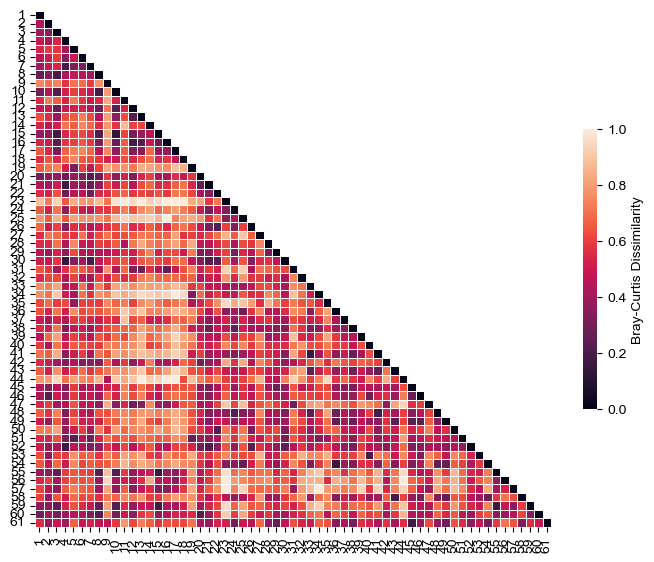

In [19]:
island_comp = island_comp.div(island_comp.sum(axis=1), axis=0)
island_comp_filled = island_comp.fillna(0)

# Calculate Bray-Curtis distance
distances = pdist(island_comp_filled.values, metric='braycurtis')

# Convert the condensed distance matrix to a square matrix
distance_matrix = squareform(distances)

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(distance_matrix, dtype=bool),k=1)

plt.figure(figsize=(7, 6))
axis_labels = np.arange(1, len(distance_matrix)+1)
sns.heatmap(distance_matrix, 
            mask=mask, 
            cmap='rocket', 
            vmin=0.0,
            vmax=1.0, 
            annot=False, 
            square=True, 
            linewidths=.5, 
            xticklabels=axis_labels, 
            yticklabels=axis_labels,
            cbar_kws={"shrink": .5, "label": "Bray-Curtis Dissimilarity"})

plt.title('')
plt.tight_layout()
plt.show()

## Perform Ecospatial Analysis on all samples

In [4]:
library_ids = adata.obs['sample'].unique().tolist()

### Calculate MDI

In [5]:
# Define the sequence of scales
scales = [1., 2., 4., 8., 16., 32., 64.]

# make them into one when returned
mdi_results = eco.calculate_MDI(spatial_data=adata,
                                scales=scales,
                                library_key='sample',
                                library_id=library_ids,
                                spatial_key='spatial',
                                cluster_key='cell_type',
                                random_patch=False,
                                plotfigs=False,
                                savefigs=False,
                                patch_kwargs={'random_seed': None, 'min_points':2},
                                other_kwargs={'metric': 'Shannon Diversity'})

Processing region: BALBc-1 at scale 1.0
0.000 per cent patches are empty
BALBc-1 at scale 1.0 has 0 patches with zero diveristy
BALBc-1 at scale 1.0 diversity is 2.8224049147168166
Processing region: BALBc-2 at scale 1.0
0.000 per cent patches are empty
BALBc-2 at scale 1.0 has 0 patches with zero diveristy
BALBc-2 at scale 1.0 diversity is 2.8742375282078143
Processing region: BALBc-3 at scale 1.0
0.000 per cent patches are empty
BALBc-3 at scale 1.0 has 0 patches with zero diveristy
BALBc-3 at scale 1.0 diversity is 2.8116755585127406
Processing region: MRL-4 at scale 1.0
0.000 per cent patches are empty
MRL-4 at scale 1.0 has 0 patches with zero diveristy
MRL-4 at scale 1.0 diversity is 3.126137234736102
Processing region: MRL-5 at scale 1.0
0.000 per cent patches are empty
MRL-5 at scale 1.0 has 0 patches with zero diveristy
MRL-5 at scale 1.0 diversity is 3.2585089241112524
Processing region: MRL-6 at scale 1.0
0.000 per cent patches are empty
MRL-6 at scale 1.0 has 0 patches with

In [6]:
mdi_results

,1.0,2.0,4.0,8.0,16.0,32.0,64.0,Slope
BALBc-1,2.822405,2.809634,2.678405,2.479999,2.286807,2.066045,1.721111,0.185095
BALBc-2,2.874238,2.838216,2.685395,2.526869,2.305148,2.077747,1.732378,0.190242
BALBc-3,2.811676,2.741065,2.63052,2.463874,2.255114,2.004529,1.659183,0.189498
MRL-4,3.126137,3.083159,2.986427,2.78146,2.55512,2.269588,1.792999,0.216352
MRL-5,3.258509,3.059884,2.811016,2.543652,2.333971,2.038872,1.585257,0.269244
MRL-6,3.34431,3.086245,2.95716,2.744414,2.548276,2.283961,1.83675,0.233433
MRL-7,3.128434,2.99235,2.730446,2.491934,2.286958,2.026418,1.618829,0.246577
MRL-8,3.465678,3.292377,3.090165,2.866161,2.631289,2.332991,1.871333,0.255739
MRL-9,3.371959,3.200401,3.067467,2.848272,2.669482,2.417582,1.985302,0.218700


In [7]:
# Add 'Condition' and 'Sample_id' to the columns
mdi_results['Condition'] = ' '
mdi_results['Sample_id'] = mdi_results.index
mdi_results.loc[mdi_results.index.str.contains('BALBc'), 'Condition'] = 'BALBc'
mdi_results.loc[mdi_results.index.str.contains('MRL'), 'Condition'] = 'MRL'
mdi_results.head()

,1.0,2.0,4.0,8.0,16.0,32.0,64.0,Slope,Condition,Sample_id
BALBc-1,2.822405,2.809634,2.678405,2.479999,2.286807,2.066045,1.721111,0.185095,BALBc,BALBc-1
BALBc-2,2.874238,2.838216,2.685395,2.526869,2.305148,2.077747,1.732378,0.190242,BALBc,BALBc-2
BALBc-3,2.811676,2.741065,2.63052,2.463874,2.255114,2.004529,1.659183,0.189498,BALBc,BALBc-3
MRL-4,3.126137,3.083159,2.986427,2.78146,2.55512,2.269588,1.792999,0.216352,MRL,MRL-4
MRL-5,3.258509,3.059884,2.811016,2.543652,2.333971,2.038872,1.585257,0.269244,MRL,MRL-5


### Calculate GDI

In [9]:
gdi_results = eco.calculate_GDI(spatial_data=adata, 
                                scale=64.0, 
                                library_key='sample',
                                library_id=library_ids, 
                                spatial_key='spatial',
                                cluster_key='cell_type',
                                hotspot=True,
                                restricted=False,
                                metric='Shannon Diversity')
gdi_results

Processing region: BALBc-1 at scale 64.0
2.222 per cent patches are empty
Processing region: BALBc-2 at scale 64.0
5.542 per cent patches are empty
Processing region: BALBc-3 at scale 64.0
7.812 per cent patches are empty
Processing region: MRL-4 at scale 64.0
0.708 per cent patches are empty
Processing region: MRL-5 at scale 64.0
0.708 per cent patches are empty
Processing region: MRL-6 at scale 64.0
0.220 per cent patches are empty
Processing region: MRL-7 at scale 64.0
0.220 per cent patches are empty
Processing region: MRL-8 at scale 64.0
0.098 per cent patches are empty
Processing region: MRL-9 at scale 64.0
0.000 per cent patches are empty


,GDI
BALBc-1,0.639407
BALBc-2,0.689433
BALBc-3,0.696760
MRL-4,0.489871
MRL-5,0.465093
MRL-6,0.424368
MRL-7,0.463416
MRL-8,0.379494
MRL-9,0.433336


### Calculate DPI

In [10]:
# Calculate DPI for hotspots
dpi_results = eco.calculate_DPI(spatial_data=adata, 
                                scale=64.0, 
                                library_key='sample',
                                library_id=library_ids, 
                                spatial_key='spatial',
                                cluster_key='cell_type',
                                hotspot=True,
                                metric='Shannon Diversity')
dpi_results

Processing region: BALBc-1 at scale 64.0
2.222 per cent patches are empty
Region BALBc-1 contains 687 diversity hotspots
48 islands identified
Processing region: BALBc-2 at scale 64.0
5.542 per cent patches are empty
Region BALBc-2 contains 851 diversity hotspots
47 islands identified
Processing region: BALBc-3 at scale 64.0
7.812 per cent patches are empty
Region BALBc-3 contains 712 diversity hotspots
46 islands identified
Processing region: MRL-4 at scale 64.0
0.708 per cent patches are empty
Region MRL-4 contains 480 diversity hotspots
53 islands identified
Processing region: MRL-5 at scale 64.0
0.708 per cent patches are empty
Region MRL-5 contains 443 diversity hotspots
43 islands identified
Processing region: MRL-6 at scale 64.0
0.220 per cent patches are empty
Region MRL-6 contains 326 diversity hotspots
61 islands identified
Processing region: MRL-7 at scale 64.0
0.220 per cent patches are empty
Region MRL-7 contains 499 diversity hotspots
46 islands identified
Processing regi

,DPI
BALBc-1,404.254256
BALBc-2,506.251921
BALBc-3,425.808947
MRL-4,270.151840
MRL-5,224.575542
MRL-6,135.896041
MRL-7,262.844537
MRL-8,183.255600
MRL-9,208.151759


### Calculate Global Cell Frequency & Cell Co-Occurrence

In [5]:
global_cellfreq_df, global_co_occurrence_df = eco.spot_cellfreq(spatial_data=adata, 
                                                                     scale=64.0, 
                                                                     library_key='sample',
                                                                     library_id=library_ids, 
                                                                     spatial_key='spatial',
                                                                     cluster_key='cell_type',
                                                                     mode='global',
                                                                     top=None,
                                                                     selected_comb=None,
                                                                     restricted=False,
                                                                     metric='Shannon Diversity')

Processing region: BALBc-1 at scale 64.0
2.222 per cent patches are empty
Considering whole tissue
Processing region: BALBc-2 at scale 64.0
5.542 per cent patches are empty
Considering whole tissue
Processing region: BALBc-3 at scale 64.0
7.812 per cent patches are empty
Considering whole tissue
Processing region: MRL-4 at scale 64.0
0.708 per cent patches are empty
Considering whole tissue
Processing region: MRL-5 at scale 64.0
0.708 per cent patches are empty
Considering whole tissue
Processing region: MRL-6 at scale 64.0
0.220 per cent patches are empty
Considering whole tissue
Processing region: MRL-7 at scale 64.0
0.220 per cent patches are empty
Considering whole tissue
Processing region: MRL-8 at scale 64.0
0.098 per cent patches are empty
Considering whole tissue
Processing region: MRL-9 at scale 64.0
0.000 per cent patches are empty
Considering whole tissue


In [6]:
global_cellfreq_df['Condition'] = ' '
global_cellfreq_df.loc[global_cellfreq_df.index.str.contains('BALBc'), 'Condition'] = 'BALBc'
global_cellfreq_df.loc[global_cellfreq_df.index.str.contains('MRL'), 'Condition'] = 'MRL'

global_co_occurrence_subcols = global_co_occurrence_df.loc[:,global_co_occurrence_df.mean()>0.05].columns.tolist()
global_co_occurrence_df['Condition'] = ' '
global_co_occurrence_df['Mouse'] = global_co_occurrence_df.index
global_co_occurrence_df.loc[global_co_occurrence_df.index.str.contains('BALBc'), 'Condition'] = 'BALBc'
global_co_occurrence_df.loc[global_co_occurrence_df.index.str.contains('MRL'), 'Condition'] = 'MRL'
global_co_occurrence_subcols.extend([('Condition',''),('Mouse','')])

In [7]:
# Melt the dataframe for easier plotting and statistical analysis
global_cellfreq_df_melt = global_cellfreq_df.reset_index().melt(id_vars=['sample', 'Condition'])
global_cellfreq_df_melt.columns = ['sample', 'group', 'cell_type', 'Frequency']

global_cellfreq_df_melt

,sample,group,cell_type,Frequency
0,BALBc-1,BALBc,B220(+) DN T cells,0.003969
1,BALBc-2,BALBc,B220(+) DN T cells,0.003772
2,BALBc-3,BALBc,B220(+) DN T cells,0.005446
3,MRL-4,MRL,B220(+) DN T cells,0.014466
4,MRL-5,MRL,B220(+) DN T cells,0.019893
...,...,...,...,...
238,MRL-5,MRL,plasma cells,0.003016
239,MRL-6,MRL,plasma cells,0.013661
240,MRL-7,MRL,plasma cells,0.003686
241,MRL-8,MRL,plasma cells,0.016240


B cells has p value of 0.006408963135728074
B220(+) DN T cells has p value of 0.08363460243637065
CD106(+)CD16/32(+)CD31(+) stroma has p value of 0.10246220899780342
CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma has p value of 0.04098951744156447
CD106(+)CD16/32(-)Ly6C(+)CD31(+) has p value of 0.48760707221130684
CD106(-)CD16/32(+)Ly6C(+)CD31(-) has p value of 0.00014746290448731814
CD106(-)CD16/32(-)Ly6C(+)CD31(+) stroma has p value of 0.029644306916028648
CD11c(+) B cells has p value of 0.04433015687789797
CD3(+) other markers (-) has p value of 0.0039461017917897965
CD31(hi) vascular has p value of 0.744873603519344
CD4(+) T cells has p value of 0.23629828012676266
CD4(+)CD8(-)cDC has p value of 0.002101995902806824
CD4(+)MHCII(+) has p value of 0.27737999550550363
CD4(-)CD8(+)cDC has p value of 0.00013225110887609995
CD4(-)CD8(-) cDC has p value of 0.13322938432638706
CD8(+) T cells has p value of 0.8144572874311375
ERTR7(+) stroma has p value of 0.5151830491689221
F4/80(+) mphs has p va

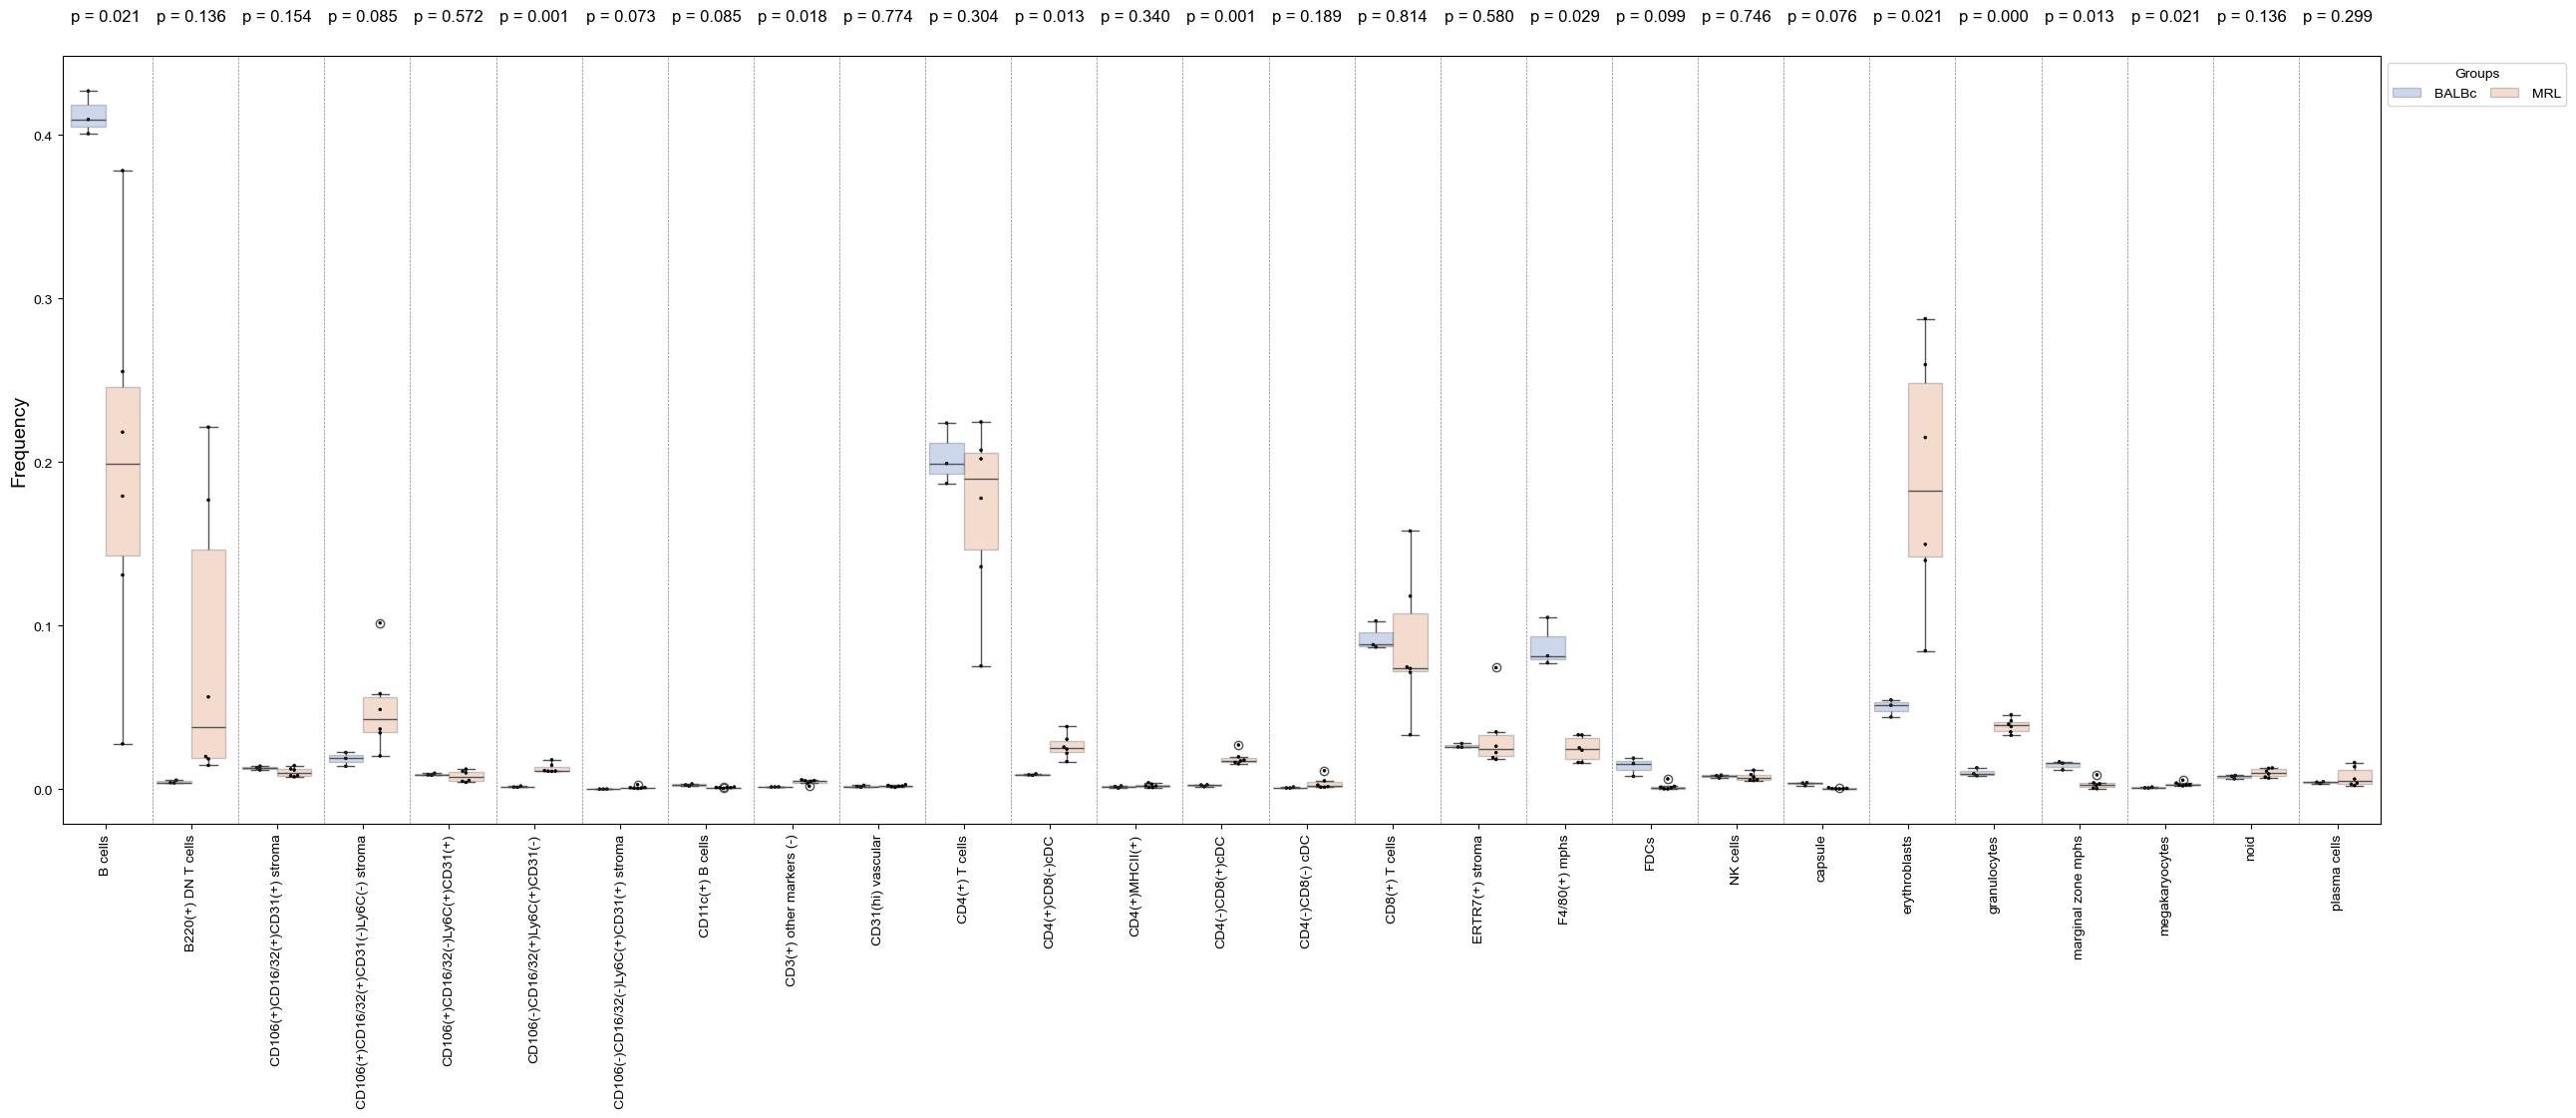

In [8]:
# Perform t-tests
selected_cell_types = sorted(adata.obs['cell_type'].unique())
selected_p_values = []
for ct in selected_cell_types:
    group1 = global_cellfreq_df_melt[(global_cellfreq_df_melt['cell_type'] == ct) & (global_cellfreq_df_melt['group'] == 'BALBc')]['Frequency']
    group2 = global_cellfreq_df_melt[(global_cellfreq_df_melt['cell_type'] == ct) & (global_cellfreq_df_melt['group'] == 'MRL')]['Frequency']
    t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)
    print(f"{ct} has p value of {p_value}")
    selected_p_values.append(p_value)

pvals_corrected = stats.false_discovery_control(selected_p_values, method='bh')
print('-'*42)
print(f"p-values after correction:")

# Plot
fig, ax = plt.subplots(figsize=(30,10))
sns.boxplot(data=global_cellfreq_df_melt, x='cell_type', y='Frequency', hue='group', palette='muted', boxprops=dict(alpha=.3), ax=ax, dodge=True, order=selected_cell_types)
sns.swarmplot(data=global_cellfreq_df_melt, x='cell_type', y='Frequency', hue='group', palette='dark:black', size=2.0, dodge=True, order=selected_cell_types, ax=ax, edgecolor='auto', linewidth=0.5)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], title="Groups", handletextpad=1, columnspacing=1, bbox_to_anchor=(1, 1), ncol=3, frameon=True)
plt.xticks(rotation=90)

p_vals_corrected_dict = {}
yrange = ax.get_ylim()[1] - ax.get_ylim()[0]
for i, ct in enumerate(selected_cell_types):
    ax.text(i, yrange, f"p = {pvals_corrected[i]:.3f}", ha='center', fontsize=12, rotation=0)
    print(f"{ct} has p value = {pvals_corrected[i]:.3f}", flush=True)
    p_vals_corrected_dict[ct] = pvals_corrected[i]
    
for i in range(len(selected_cell_types) - 1):
    ax.axvline(i + 0.55, color='grey', linestyle='--', linewidth=0.5)
    
ax.set_ylabel("Frequency", fontsize=14)
ax.set_xlabel('') 
plt.show()

### Calculate Cell Frequency and Cell Co-Occurrence in hot/coldspots

In [9]:
spot_cellfreq_df, spot_co_occurrence_df = eco.spot_cellfreq(spatial_data=adata, 
                                                            scale=64.0, 
                                                            library_key='sample',
                                                            library_id=library_ids, 
                                                            spatial_key='spatial',
                                                            cluster_key='cell_type',
                                                            mode='hot',
                                                            top=None,
                                                            selected_comb=None,
                                                            restricted=False,
                                                            metric='Shannon Diversity')

Processing region: BALBc-1 at scale 64.0
2.222 per cent patches are empty
Region BALBc-1 contains 687 diversity hotspots
Processing region: BALBc-2 at scale 64.0
5.542 per cent patches are empty
Region BALBc-2 contains 851 diversity hotspots
Processing region: BALBc-3 at scale 64.0
7.812 per cent patches are empty
Region BALBc-3 contains 712 diversity hotspots
Processing region: MRL-4 at scale 64.0
0.708 per cent patches are empty
Region MRL-4 contains 480 diversity hotspots
Processing region: MRL-5 at scale 64.0
0.708 per cent patches are empty
Region MRL-5 contains 443 diversity hotspots
Processing region: MRL-6 at scale 64.0
0.220 per cent patches are empty
Region MRL-6 contains 326 diversity hotspots
Processing region: MRL-7 at scale 64.0
0.220 per cent patches are empty
Region MRL-7 contains 499 diversity hotspots
Processing region: MRL-8 at scale 64.0
0.098 per cent patches are empty
Region MRL-8 contains 331 diversity hotspots
Processing region: MRL-9 at scale 64.0
0.000 per cen

In [10]:
spot_cellfreq_df = spot_cellfreq_df.fillna(0).T    
spot_cellfreq_df['Condition'] = ' '
spot_cellfreq_df.loc[spot_cellfreq_df.index.str.contains('BALBc'), 'Condition'] = 'BALBc'
spot_cellfreq_df.loc[spot_cellfreq_df.index.str.contains('MRL'), 'Condition'] = 'MRL'

spot_co_occurrence_subcols = spot_co_occurrence_df.loc[:,spot_co_occurrence_df.mean()>0.05].columns.tolist()
spot_co_occurrence_df['Condition'] = ' '
spot_co_occurrence_df['Mouse'] = spot_co_occurrence_df.index
spot_co_occurrence_df.loc[spot_co_occurrence_df.index.str.contains('BALBc'), 'Condition'] = 'BALBc'
spot_co_occurrence_df.loc[spot_co_occurrence_df.index.str.contains('MRL'), 'Condition'] = 'MRL'
spot_co_occurrence_subcols.extend([('Condition',''),('Mouse','')])

In [11]:
spot_cellfreq_df['Mouse'] = spot_cellfreq_df.index

# Melt the DataFrame
spot_cellfreq_df_melt = spot_cellfreq_df.melt(id_vars=['Mouse', 'Condition'], var_name='CellType', value_name='Frequency')

p-value before correction:
B cells has p value = 0.0000
B220(+) DN T cells has p value = 0.0139
CD106(+)CD16/32(+)CD31(+) stroma has p value = 0.0097
CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma has p value = 0.0062
CD106(+)CD16/32(-)Ly6C(+)CD31(+) has p value = 0.9028
CD106(-)CD16/32(+)Ly6C(+)CD31(-) has p value = 0.0112
CD106(-)CD16/32(-)Ly6C(+)CD31(+) stroma has p value = 0.0295
CD11c(+) B cells has p value = 0.0342
CD3(+) other markers (-) has p value = 0.0460
CD31(hi) vascular has p value = 0.0861
CD4(+) T cells has p value = 0.1443
CD4(+)CD8(-)cDC has p value = 0.0067
CD4(+)MHCII(+) has p value = 0.4478
CD4(-)CD8(+)cDC has p value = 0.0015
CD4(-)CD8(-) cDC has p value = 0.1899
CD8(+) T cells has p value = 0.2234
ERTR7(+) stroma has p value = 0.2324
F4/80(+) mphs has p value = 0.0012
FDCs has p value = 0.6537
NK cells has p value = 0.2228
capsule has p value = 0.0739
erythroblasts has p value = 0.0149
granulocytes has p value = 0.0010
marginal zone mphs has p value = 0.0311
megakaryocy

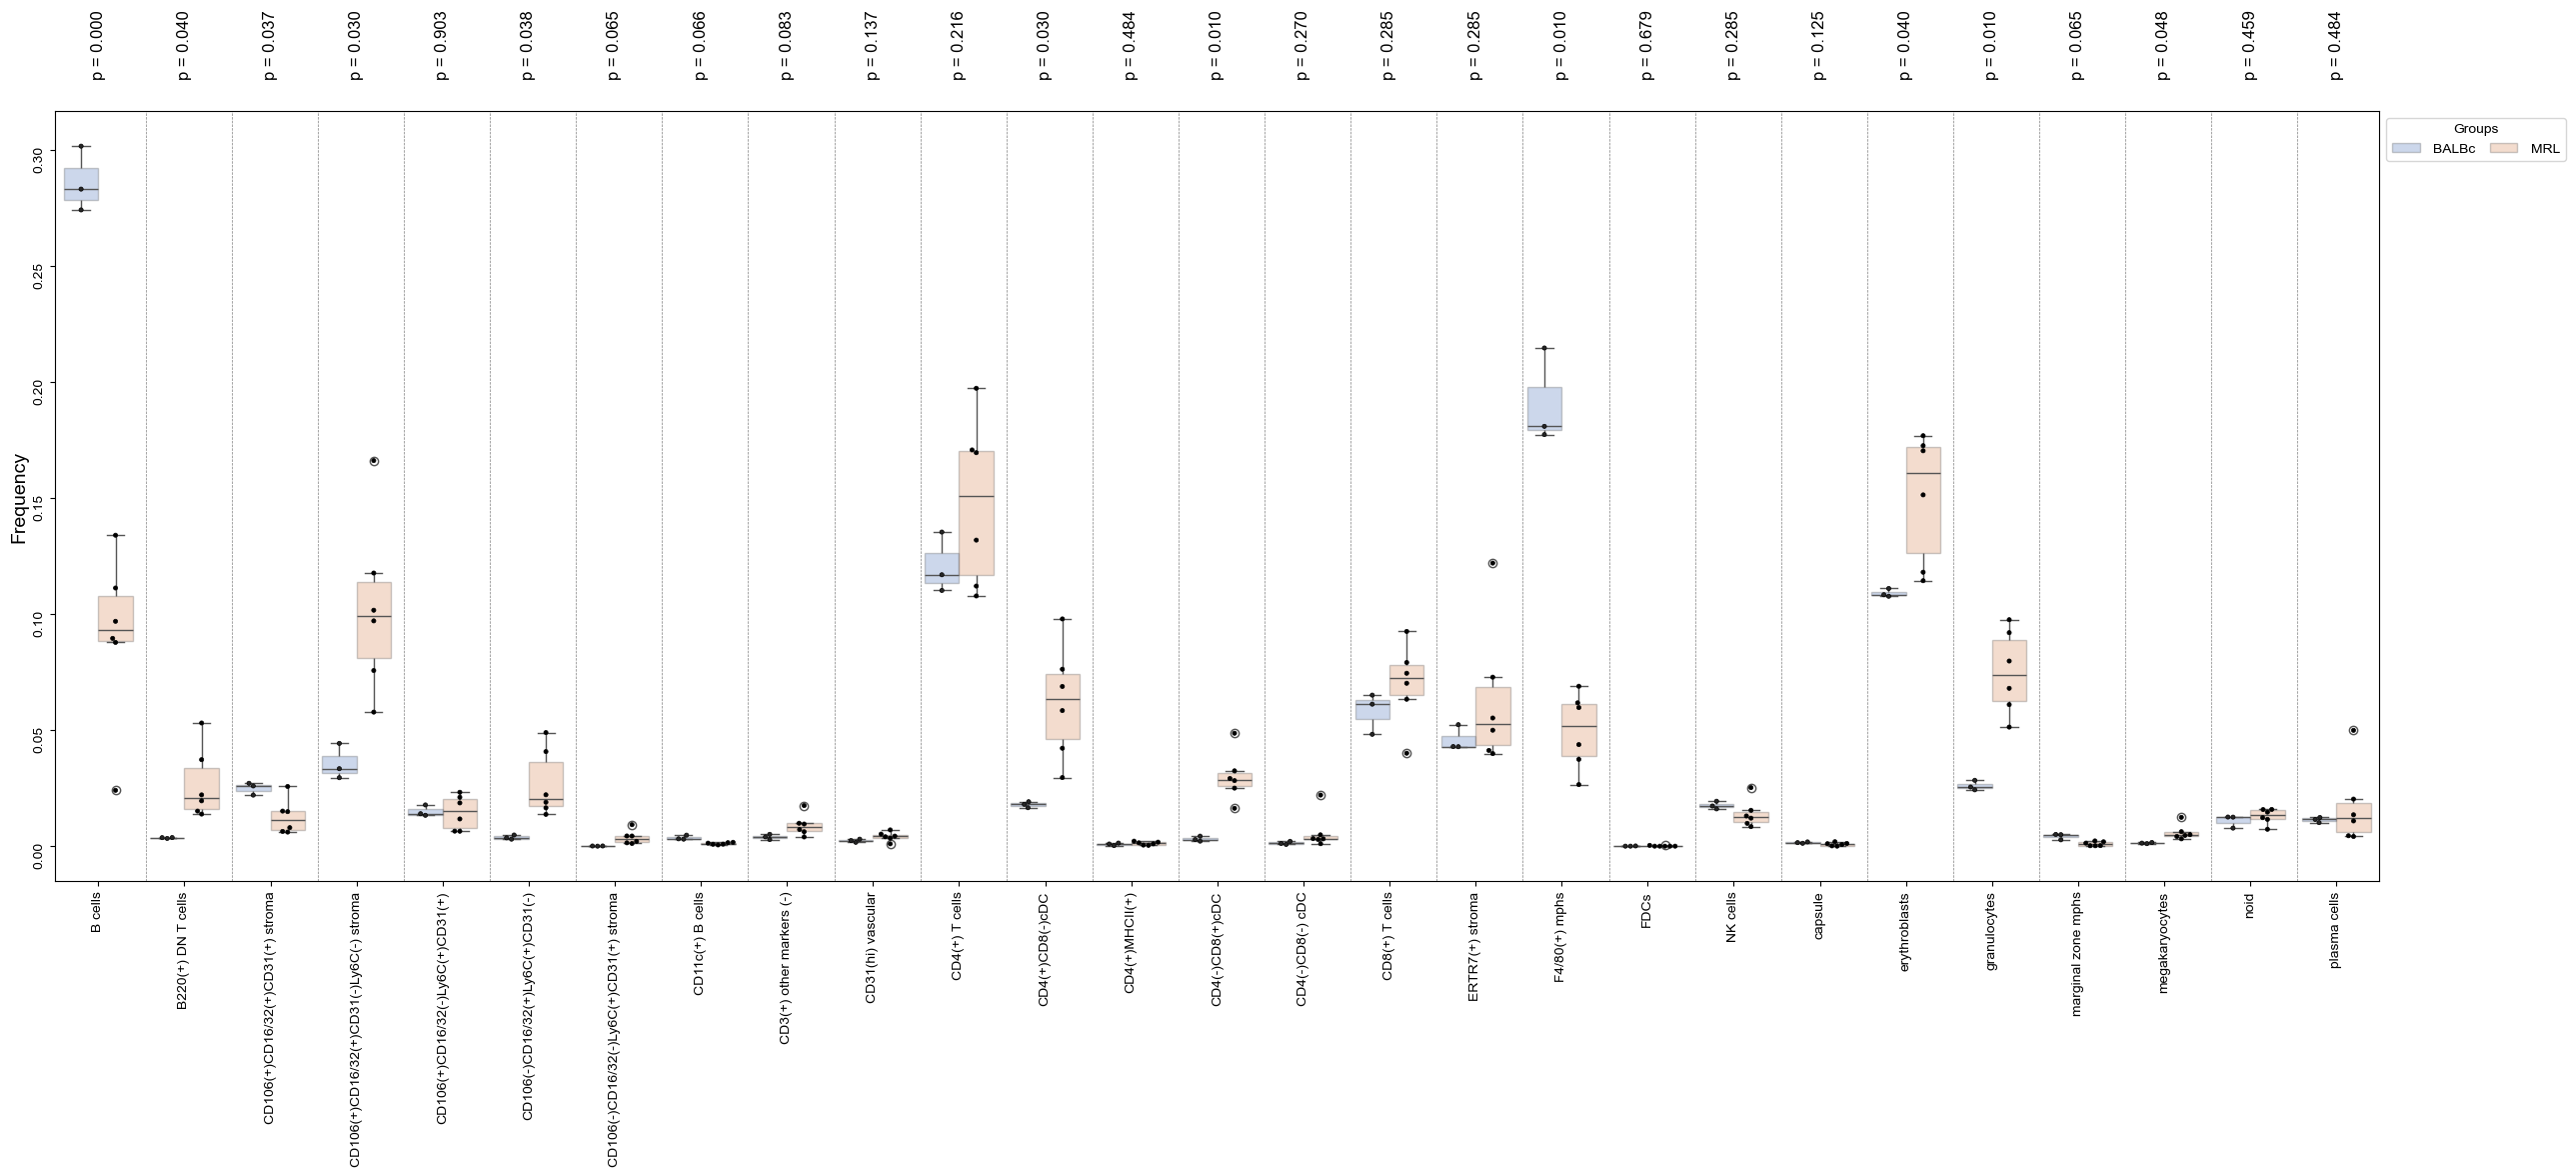

In [12]:
selected_cell_types = sorted(spot_cellfreq_df_melt['CellType'].unique())
selected_p_values = []

# Perform t-tests
print(f"p-value before correction:")
for ct in selected_cell_types: # df_melted['CellType'].unique():
    subset = spot_cellfreq_df_melt[spot_cellfreq_df_melt['CellType'] == ct]
    group1 = subset[subset['Condition'] == 'BALBc']['Frequency']
    group2 = subset[subset['Condition'] == 'MRL']['Frequency']

    t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)
    print(f"{ct} has p value = {p_value:.4f}")    
    selected_p_values.append(p_value)

# Filter the dataframe based on selected CellTypes
df_filtered = spot_cellfreq_df_melt[spot_cellfreq_df_melt['CellType'].isin(selected_cell_types)]

# Plot the filtered data
fig, ax = plt.subplots(figsize=(30,10))
sns.boxplot(data=df_filtered, x='CellType', y='Frequency', hue='Condition', palette='muted', boxprops=dict(alpha=.3), ax=ax, dodge=True,order=selected_cell_types)
sns.swarmplot(data=df_filtered, x='CellType', y='Frequency', hue='Condition', palette='dark:black', size=3.0, dodge=True, order=selected_cell_types, ax=ax, edgecolor='auto', linewidth=0.5)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], title="Groups", handletextpad=1, columnspacing=1, bbox_to_anchor=(1, 1), ncol=3, frameon=True)

spot_pvals_corrected = stats.false_discovery_control(selected_p_values, method='bh')
spot_pvals_corrected = dict(map(lambda i,j : (i,j) , selected_cell_types, spot_pvals_corrected))

print('-'*42)
print(f"p-values after correction: ")

yrange = ax.get_ylim()[1] - ax.get_ylim()[0]
for i, ct in enumerate(selected_cell_types):
    ax.text(i, yrange, f"p = {spot_pvals_corrected[ct]:.3f}", ha='center', fontsize=12, rotation=90)
    print(f"{ct} in hot spots has p value = {spot_pvals_corrected[ct]:.3f}", flush=True)
    if spot_pvals_corrected[ct] < 0.05 and p_vals_corrected_dict[ct] > 0.05:
        print(f"{ct} in whole tissue has p value = {p_vals_corrected_dict[ct]:.3f}", flush=True)
        print('*'*42)
    
for i in range(len(selected_cell_types) - 1):
    ax.axvline(i + 0.55, color='grey', linestyle='--', linewidth=0.5)
    
ax.set_ylabel("Frequency", fontsize=14)
ax.set_xlabel('')    
plt.xticks(rotation=90)  
plt.yticks(rotation=90) 
plt.show()
plt.close(fig)


### Process Cell Co-Occurrence Dataframe

In [13]:
union_cols = set(global_co_occurrence_subcols).union(set(spot_co_occurrence_subcols))

In [14]:
# Make them have the same set of columns
global_co_occurrence_df = global_co_occurrence_df.reindex(columns=union_cols).fillna(0)
spot_co_occurrence_df = spot_co_occurrence_df.reindex(columns=union_cols).fillna(0)

In [15]:
# Global Cell Co-Occurrence 
# Multi-index to single-index column
new_columns = []
for col in global_co_occurrence_df.columns:
    if isinstance(col, tuple):  # This checks if the column is a MultiIndex
        # Join only if the column name is not 'Mouse' or 'Condition'
        if "Mouse" not in col and "Condition" not in col:
            new_columns.append('&'.join(map(str, col)).strip())
        else:
            # If 'Mouse' or 'Condition' is in the column, it is not joined with '&'
            new_columns.append(col[0])
    else:
        new_columns.append(col)

global_co_occurrence_df_single = global_co_occurrence_df.copy()
global_co_occurrence_df_single.columns = new_columns
global_co_occurrence_df_single = global_co_occurrence_df_single[[col for col in global_co_occurrence_df_single.columns if 'noid' not in col]]

# Melt the DataFrame
global_co_occurrence_melted = global_co_occurrence_df_single.melt(id_vars=['Mouse', 'Condition'], var_name='Cell Combination', value_name='Frequency')
global_co_occurrence_melted

,Mouse,Condition,Cell Combination,Frequency
0,BALBc-1,BALBc,CD106(-)CD16/32(+)Ly6C(+)CD31(-)&CD4(+) T cells,0.016479
1,BALBc-2,BALBc,CD106(-)CD16/32(+)Ly6C(+)CD31(-)&CD4(+) T cells,0.025588
2,BALBc-3,BALBc,CD106(-)CD16/32(+)Ly6C(+)CD31(-)&CD4(+) T cells,0.015360
3,MRL-4,MRL,CD106(-)CD16/32(+)Ly6C(+)CD31(-)&CD4(+) T cells,0.059257
4,MRL-5,MRL,CD106(-)CD16/32(+)Ly6C(+)CD31(-)&CD4(+) T cells,0.054832
...,...,...,...,...
976,MRL-5,MRL,ERTR7(+) stroma&NK cells,0.021638
977,MRL-6,MRL,ERTR7(+) stroma&NK cells,0.019085
978,MRL-7,MRL,ERTR7(+) stroma&NK cells,0.021287
979,MRL-8,MRL,ERTR7(+) stroma&NK cells,0.027615


p-value before correction:
B cells&B220(+) DN T cells has p value = 0.034
B cells&CD106(+)CD16/32(+)CD31(+) stroma has p value = 0.001
B cells&CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma has p value = 0.161
B cells&CD106(+)CD16/32(-)Ly6C(+)CD31(+) has p value = 0.008
B cells&CD106(-)CD16/32(+)Ly6C(+)CD31(-) has p value = 0.053
B cells&CD3(+) other markers (-) has p value = 0.236
B cells&CD4(+) T cells has p value = 0.006
B cells&CD4(+)CD8(-)cDC has p value = 0.686
B cells&CD4(-)CD8(+)cDC has p value = 0.003
B cells&CD8(+) T cells has p value = 0.004
B cells&ERTR7(+) stroma has p value = 0.033
B cells&F4/80(+) mphs has p value = 0.000
B cells&NK cells has p value = 0.006
B cells&erythroblasts has p value = 0.031
B cells&granulocytes has p value = 0.960
B cells&marginal zone mphs has p value = 0.004
B cells&plasma cells has p value = 0.232
B220(+) DN T cells&CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma has p value = 0.041
B220(+) DN T cells&CD4(+) T cells has p value = 0.031
B220(+) DN T cells&CD

/var/folders/7g/phdhh_ld3dlbnrst0t60bwzr0000gn/T/ipykernel_23301/3825649457.py:22: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.swarmplot(data=df_filtered, x='Cell Combination', y='Frequency', hue='Condition', palette='dark:black', size=1.0, dodge=True,order=selected_cell_types, ax=ax, edgecolor='gray', linewidth=0.5)


------------------------------------------
p-values after correction:
B cells&B220(+) DN T cells has p value = 0.062
B cells&CD106(+)CD16/32(+)CD31(+) stroma has p value = 0.010
B cells&CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma has p value = 0.212
B cells&CD106(+)CD16/32(-)Ly6C(+)CD31(+) has p value = 0.019
B cells&CD106(-)CD16/32(+)Ly6C(+)CD31(-) has p value = 0.085
B cells&CD3(+) other markers (-) has p value = 0.286
B cells&CD4(+) T cells has p value = 0.016
B cells&CD4(+)CD8(-)cDC has p value = 0.706
B cells&CD4(-)CD8(+)cDC has p value = 0.013
B cells&CD8(+) T cells has p value = 0.014
B cells&ERTR7(+) stroma has p value = 0.061
B cells&F4/80(+) mphs has p value = 0.001
B cells&NK cells has p value = 0.016
B cells&erythroblasts has p value = 0.059
B cells&granulocytes has p value = 0.960
B cells&marginal zone mphs has p value = 0.013
B cells&plasma cells has p value = 0.285
B220(+) DN T cells&CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma has p value = 0.068
B220(+) DN T cells&CD4(+) T cell

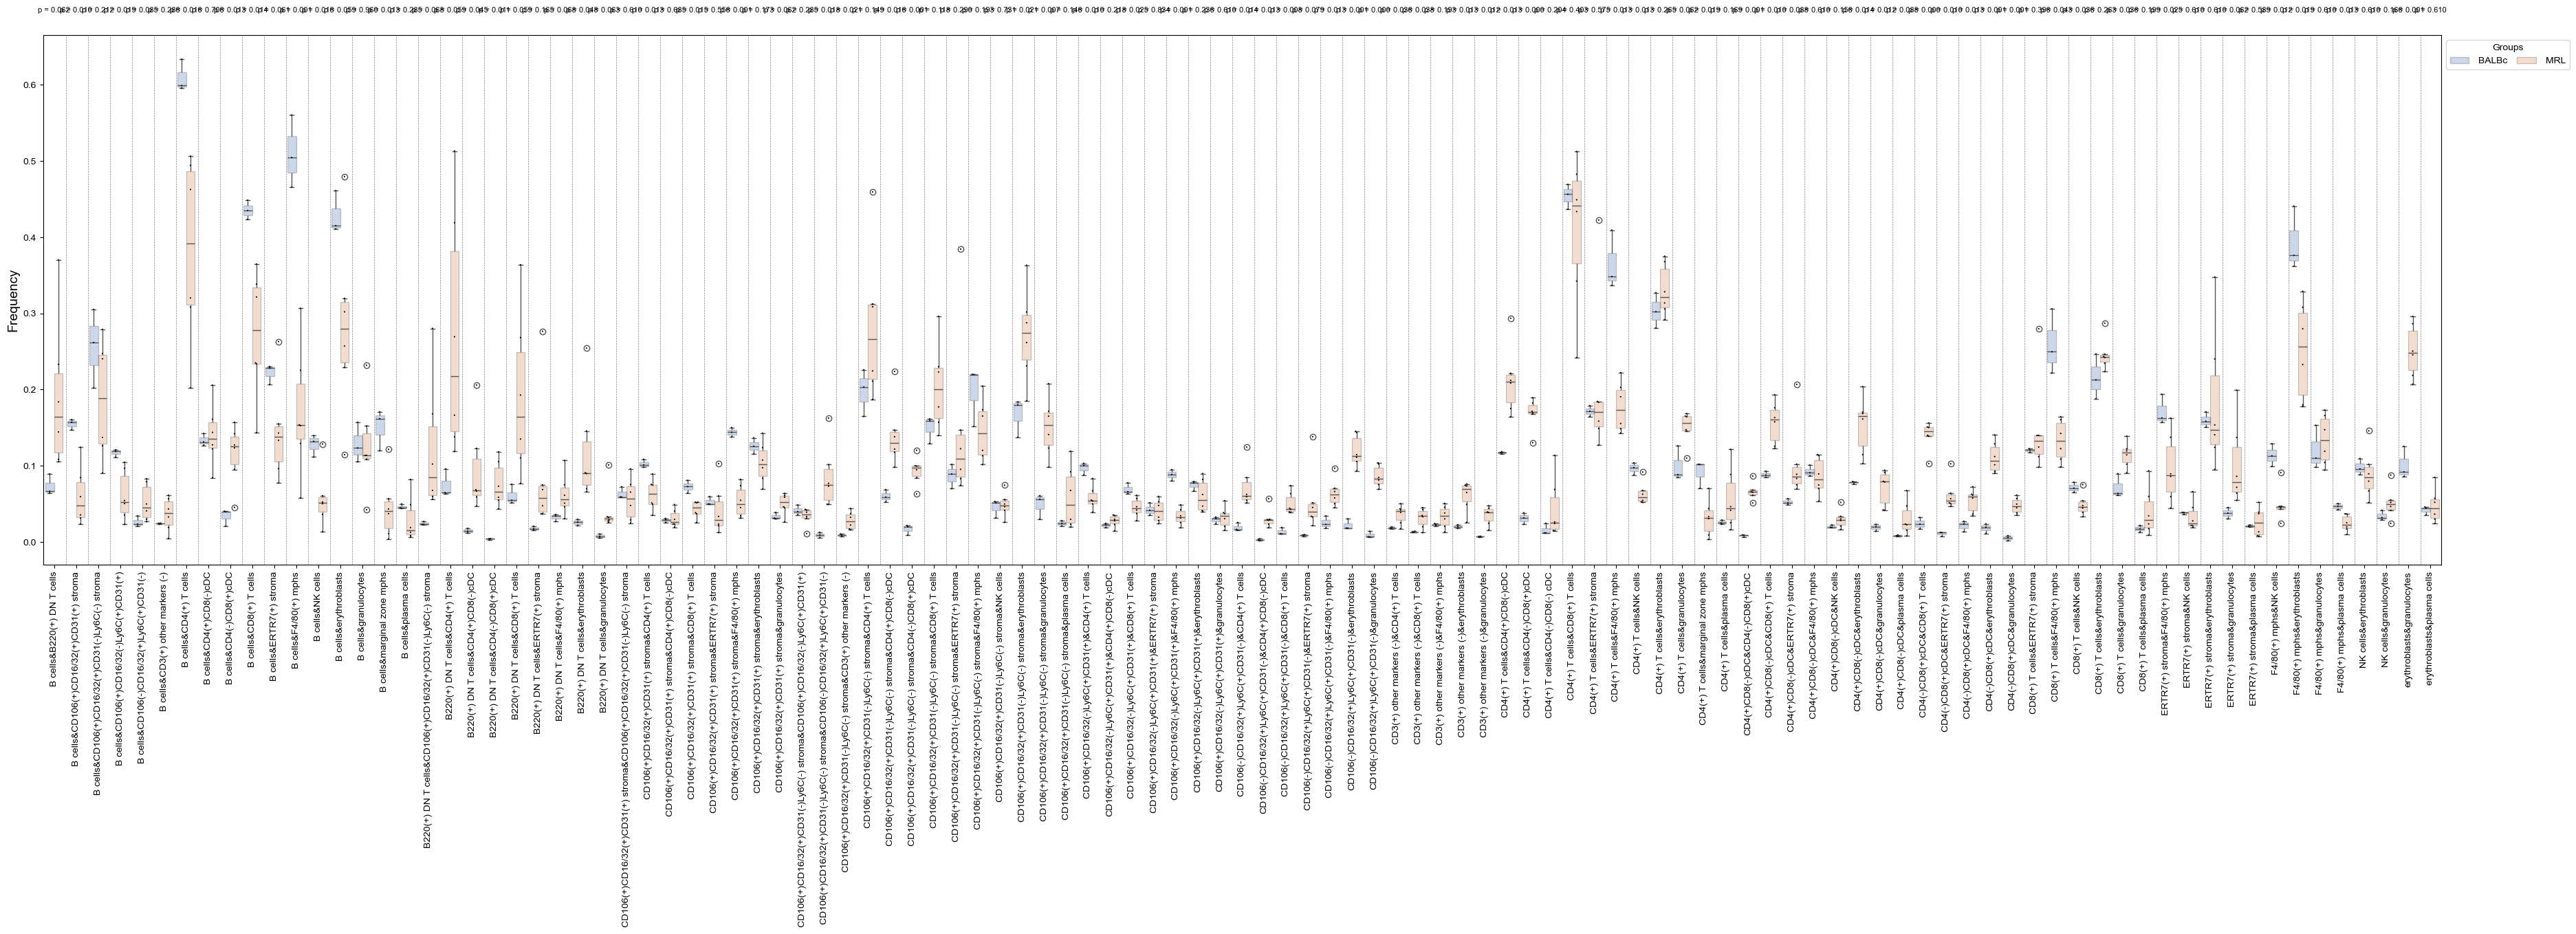

In [16]:
# Global Cell Co-Occurrence 
selected_cell_types = sorted(global_co_occurrence_melted['Cell Combination'].unique())
selected_p_values = []

# Perform t-tests
print(f"p-value before correction:")
for ct in selected_cell_types:
    subset = global_co_occurrence_melted[global_co_occurrence_melted['Cell Combination'] == ct]
    group1 = subset[subset['Condition'] == 'BALBc']['Frequency']
    group2 = subset[subset['Condition'] == 'MRL']['Frequency']

    t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)
    print(f"{ct} has p value = {p_value:.3f}")
    selected_p_values.append(p_value)

# Filter the dataframe based on selected Cell Combinations
df_filtered = global_co_occurrence_melted[global_co_occurrence_melted['Cell Combination'].isin(selected_cell_types)]

# Plot the filtered data
fig, ax = plt.subplots(figsize=(45,10))
sns.boxplot(data=df_filtered, x='Cell Combination', y='Frequency', hue='Condition', palette='muted', boxprops=dict(alpha=.3), ax=ax, dodge=True,order=selected_cell_types)
sns.swarmplot(data=df_filtered, x='Cell Combination', y='Frequency', hue='Condition', palette='dark:black', size=1.0, dodge=True,order=selected_cell_types, ax=ax, edgecolor='gray', linewidth=0.5)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], title="Groups", handletextpad=1, columnspacing=1, bbox_to_anchor=(1, 1), ncol=3, frameon=True)

pvals_corrected = stats.false_discovery_control(selected_p_values, method='bh')

print('-'*42)
print(f"p-values after correction:")

p_vals_corrected_dict = {}
yrange = ax.get_ylim()[1] - ax.get_ylim()[0]
for i, ct in enumerate(selected_cell_types):
    ax.text(i, yrange, f"p = {pvals_corrected[i]:.3f}", ha='center', fontsize=8, rotation=0)
    print(f"{ct} has p value = {pvals_corrected[i]:.3f}", flush=True)
    p_vals_corrected_dict[ct] = pvals_corrected[i]
    
for i in range(len(selected_cell_types) - 1):
    ax.axvline(i + 0.55, color='grey', linestyle='--', linewidth=0.5)
    
ax.set_ylabel("Frequency", fontsize=14)
ax.set_xlabel('')   
plt.xticks(rotation=90)  
plt.show()

In [17]:
# Spot Cell Co-Occurrence
# Multi-index to single-index column
new_columns = []
for col in spot_co_occurrence_df.columns:
    if isinstance(col, tuple):  # This checks if the column is a MultiIndex
        # Join only if the column name is not 'Mouse' or 'Condition'
        if "Mouse" not in col and "Condition" not in col:
            new_columns.append('&'.join(map(str, col)).strip())
        else:
            # If 'Mouse' or 'Condition' is in the column, it is not joined with '&'
            new_columns.append(col[0])
    else:
        new_columns.append(col)

spot_co_occurrence_df_single = spot_co_occurrence_df.copy()
spot_co_occurrence_df_single.columns = new_columns
spot_co_occurrence_df_single = spot_co_occurrence_df_single[[col for col in spot_co_occurrence_df_single.columns if 'noid' not in col]]

# Melt the DataFrame
spot_co_occurrence_melted = spot_co_occurrence_df_single.melt(id_vars=['Mouse', 'Condition'], var_name='Cell Combination', value_name='Frequency')
spot_co_occurrence_melted

,Mouse,Condition,Cell Combination,Frequency
0,BALBc-1,BALBc,CD106(-)CD16/32(+)Ly6C(+)CD31(-)&CD4(+) T cells,0.040757
1,BALBc-2,BALBc,CD106(-)CD16/32(+)Ly6C(+)CD31(-)&CD4(+) T cells,0.058754
2,BALBc-3,BALBc,CD106(-)CD16/32(+)Ly6C(+)CD31(-)&CD4(+) T cells,0.042135
3,MRL-4,MRL,CD106(-)CD16/32(+)Ly6C(+)CD31(-)&CD4(+) T cells,0.162500
4,MRL-5,MRL,CD106(-)CD16/32(+)Ly6C(+)CD31(-)&CD4(+) T cells,0.128668
...,...,...,...,...
976,MRL-5,MRL,ERTR7(+) stroma&NK cells,0.056433
977,MRL-6,MRL,ERTR7(+) stroma&NK cells,0.052147
978,MRL-7,MRL,ERTR7(+) stroma&NK cells,0.052104
979,MRL-8,MRL,ERTR7(+) stroma&NK cells,0.057402


p-value before correction: 
B cells&B220(+) DN T cells has p value = 0.004
B cells&CD106(+)CD16/32(+)CD31(+) stroma has p value = 0.000
B cells&CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma has p value = 0.252
B cells&CD106(+)CD16/32(-)Ly6C(+)CD31(+) has p value = 0.008
B cells&CD106(-)CD16/32(+)Ly6C(+)CD31(-) has p value = 0.093
B cells&CD3(+) other markers (-) has p value = 0.390
B cells&CD4(+) T cells has p value = 0.006
B cells&CD4(+)CD8(-)cDC has p value = 0.408
B cells&CD4(-)CD8(+)cDC has p value = 0.007
B cells&CD8(+) T cells has p value = 0.016
B cells&ERTR7(+) stroma has p value = 0.027
B cells&F4/80(+) mphs has p value = 0.000
B cells&NK cells has p value = 0.010
B cells&erythroblasts has p value = 0.004
B cells&granulocytes has p value = 0.679
B cells&marginal zone mphs has p value = 0.024
B cells&plasma cells has p value = 0.314
B220(+) DN T cells&CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma has p value = 0.010
B220(+) DN T cells&CD4(+) T cells has p value = 0.002
B220(+) DN T cells&C

/var/folders/7g/phdhh_ld3dlbnrst0t60bwzr0000gn/T/ipykernel_23301/1275659436.py:22: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.swarmplot(data=df_filtered, x='Cell Combination', y='Frequency', hue='Condition', palette='dark:black', size=2.0, dodge=True,order=selected_cell_types, ax=ax, edgecolor='gray', linewidth=0.5)


------------------------------------------
p-values after correction:
B cells&B220(+) DN T cells in hot spots has p value = 0.015
B cells&B220(+) DN T cells in whole tissue has p value = 0.062
******************************************
B cells&CD106(+)CD16/32(+)CD31(+) stroma in hot spots has p value = 0.002
B cells&CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma in hot spots has p value = 0.316
B cells&CD106(+)CD16/32(-)Ly6C(+)CD31(+) in hot spots has p value = 0.022
B cells&CD106(-)CD16/32(+)Ly6C(+)CD31(-) in hot spots has p value = 0.137
B cells&CD3(+) other markers (-) in hot spots has p value = 0.446
B cells&CD4(+) T cells in hot spots has p value = 0.019
B cells&CD4(+)CD8(-)cDC in hot spots has p value = 0.458
B cells&CD4(-)CD8(+)cDC in hot spots has p value = 0.021
B cells&CD8(+) T cells in hot spots has p value = 0.033
B cells&ERTR7(+) stroma in hot spots has p value = 0.047
B cells&ERTR7(+) stroma in whole tissue has p value = 0.061
******************************************
B cells&F

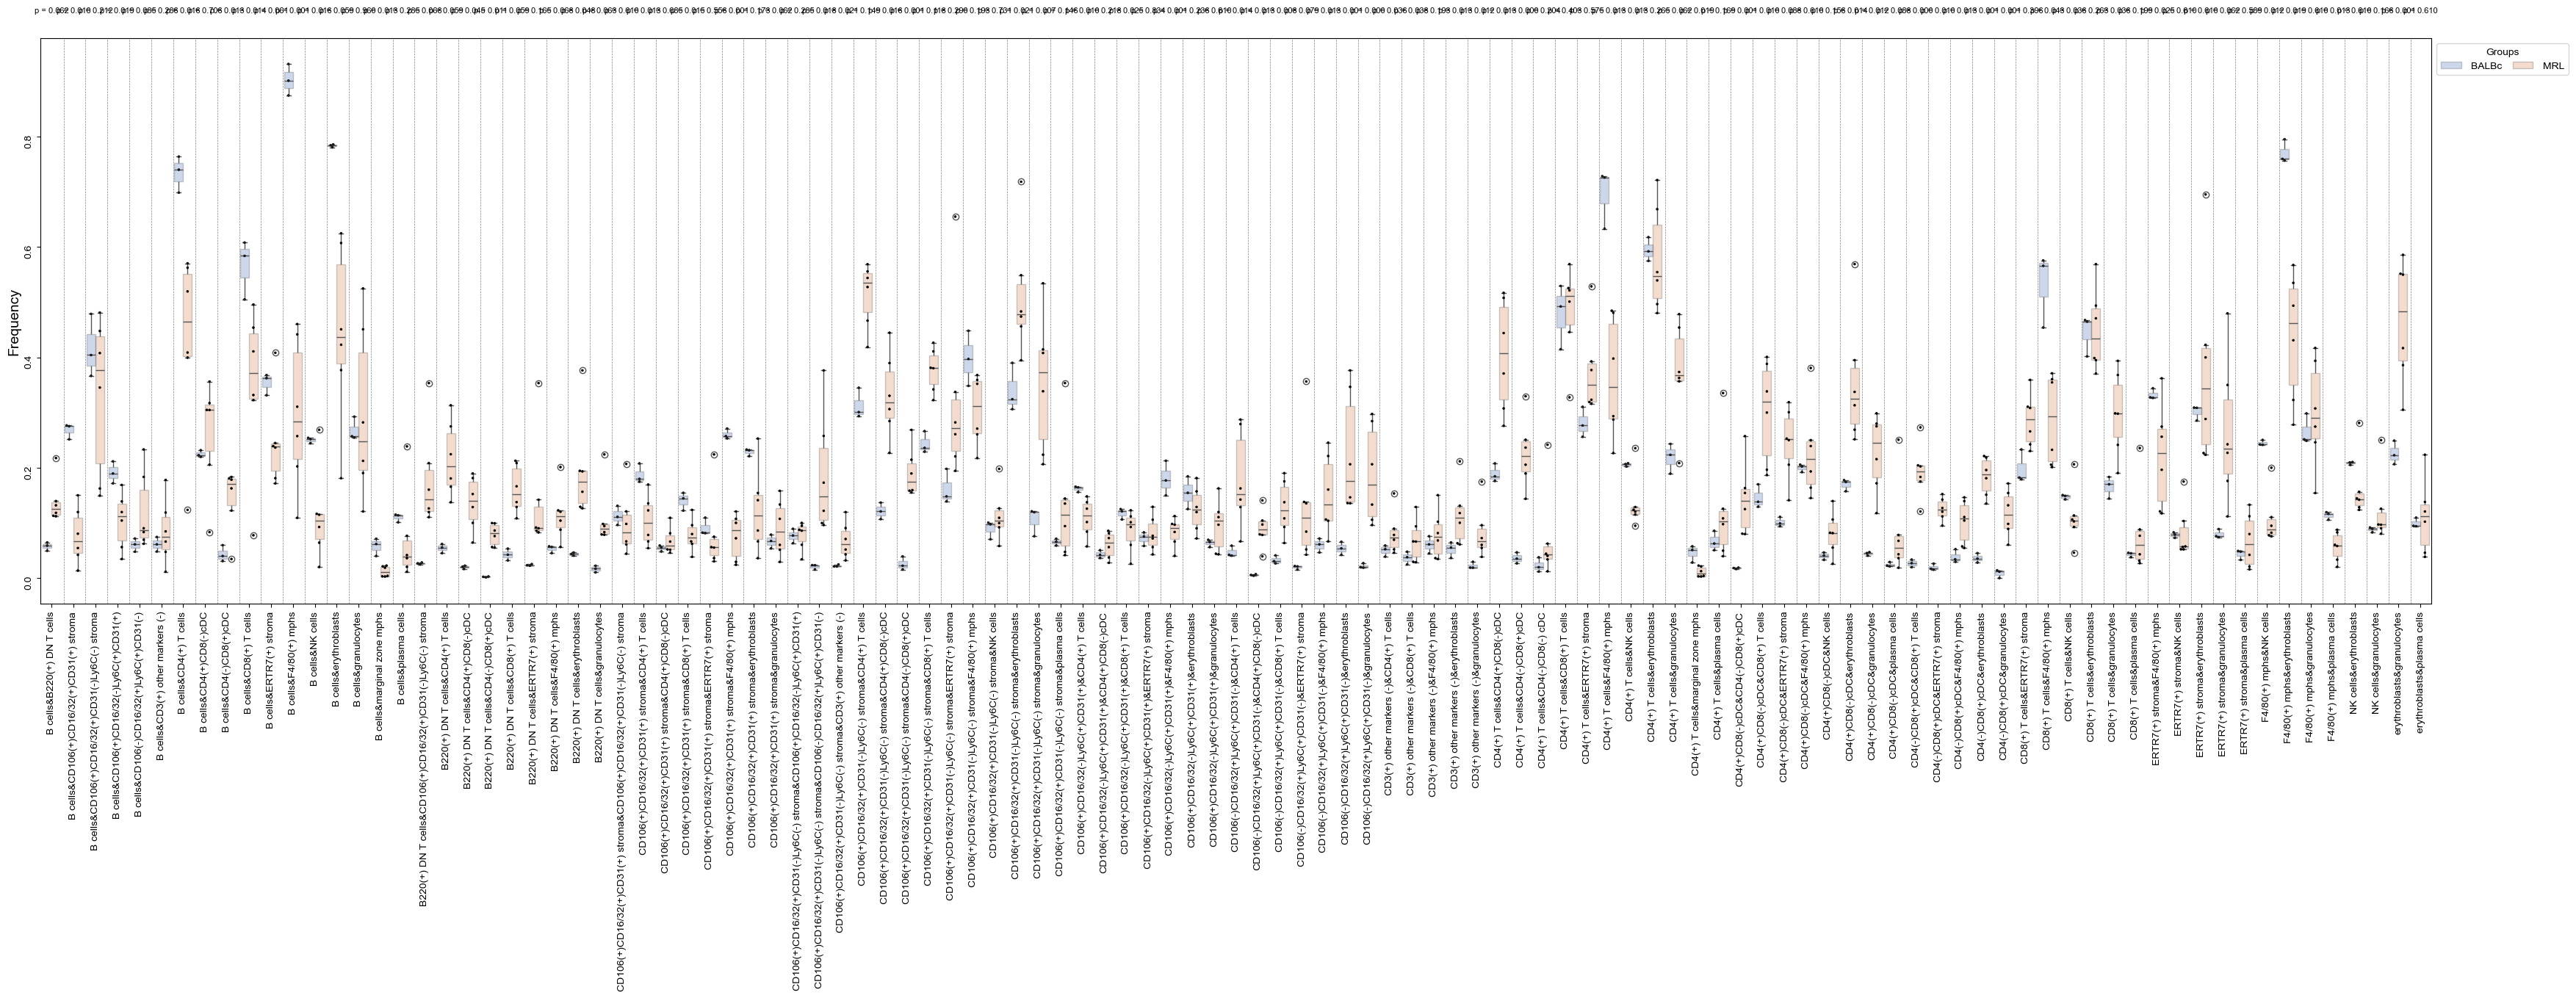

In [18]:
# Spot Cell Co-Occurrence    
selected_cell_types = sorted(spot_co_occurrence_melted['Cell Combination'].unique())
selected_p_values = []

# Perform t-tests
print(f"p-value before correction: ")
for ct in selected_cell_types: # df_melted['CellType'].unique():
    subset = spot_co_occurrence_melted[spot_co_occurrence_melted['Cell Combination'] == ct]
    group1 = subset[subset['Condition'] == 'BALBc']['Frequency']
    group2 = subset[subset['Condition'] == 'MRL']['Frequency']

    t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)
    print(f"{ct} has p value = {p_value:.3f}")
    selected_p_values.append(p_value)

# Filter the dataframe based on selected CellTypes
df_filtered = spot_co_occurrence_melted[spot_co_occurrence_melted['Cell Combination'].isin(selected_cell_types)]

# Plot the filtered data
fig, ax = plt.subplots(figsize=(42,10))
sns.boxplot(data=df_filtered, x='Cell Combination', y='Frequency', hue='Condition', palette='muted', boxprops=dict(alpha=.3), ax=ax, dodge=True,order=selected_cell_types)
sns.swarmplot(data=df_filtered, x='Cell Combination', y='Frequency', hue='Condition', palette='dark:black', size=2.0, dodge=True,order=selected_cell_types, ax=ax, edgecolor='gray', linewidth=0.5)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], title="Groups", handletextpad=1, columnspacing=1, bbox_to_anchor=(1, 1), ncol=3, frameon=True)

hot_pvals_corrected = stats.false_discovery_control(selected_p_values, method='bh')

print('-'*42)
print(f"p-values after correction:")

highlighted_comb = []
yrange = ax.get_ylim()[1] - ax.get_ylim()[0]
for i, ct in enumerate(selected_cell_types):
    ax.text(i, yrange, f"p = {pvals_corrected[i]:.3f}", ha='center', fontsize=8, rotation=0)
    print(f"{ct} in hot spots has p value = {hot_pvals_corrected[i]:.3f}", flush=True)
    if hot_pvals_corrected[i] < 0.05 and p_vals_corrected_dict[ct] >= 0.05:
        highlighted_comb.append(tuple(map(str.strip, ct.split('&'))))
        print(f"{ct} in whole tissue has p value = {p_vals_corrected_dict[ct]:.3f}", flush=True)
        print('*'*42)
    
for i in range(len(selected_cell_types) - 1):
    ax.axvline(i + 0.55, color='grey', linestyle='--', linewidth=0.5)
    
ax.set_ylabel("Frequency", fontsize=14)
ax.set_xlabel('')   
plt.xticks(rotation=90)  
plt.yticks(rotation=90)  
plt.show()

### Cell Co-Occurrence Circle Plot

In [19]:
circoplot_df1 = global_co_occurrence_df.sort_index(axis=1, level=[0,1]).drop(columns=['Mouse'])
circoplot_df1 = circoplot_df1[[col for col in circoplot_df1.columns if 'noid' not in col]]
# Group by 'Condition' and calculate the mean of the other columns
circoplot_df1 = circoplot_df1.groupby('Condition').mean().reset_index()
circoplot_df1 = circoplot_df1.set_index('Condition')
circoplot_df1

B cells                                   \
          B220(+) DN T cells CD106(+)CD16/32(+)CD31(+) stroma   
Condition                                                       
BALBc               0.073364                         0.154887   
MRL                 0.190871                         0.059676   

                                                   \
          CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma   
Condition                                           
BALBc                                    0.256508   
MRL                                      0.186811   

                                                                             \
          CD106(+)CD16/32(-)Ly6C(+)CD31(+) CD106(-)CD16/32(+)Ly6C(+)CD31(-)   
Condition                                                                     
BALBc                             0.117092                         0.026082   
MRL                               0.060700                         0.051504   

                                                                   \
          CD3(+) other markers (-) CD4(+) T cells CD4(+)CD8(-)cDC   
Condition                                                           
BALBc                     0.024203       0.609478        0.133404   
MRL                       0.036226       0.382356        0.140771   

                                          ... ERTR7(+) stroma               \
          CD4(-)CD8(+)cDC CD8(+) T cells  ...    granulocytes plasma cells   
Condition                                 ...                                
BALBc            0.033559       0.435705  ...        0.037708     0.020787   
MRL              0.115103       0.272822  ...        0.102183     0.026166   

          F4/80(+) mphs                                              NK cells  \
               NK cells erythroblasts granulocytes plasma cells erythroblasts   
Condition                                                                       
BALBc           0.11371      0.393021     0.120370     0.046403      0.097886   
MRL             0.04952      0.251273     0.133979     0.024188      0.089268   

                       erythroblasts               
          granulocytes  granulocytes plasma cells  
Condition                                          
BALBc         0.034235      0.101013     0.041810  
MRL           0.051191      0.250753     0.047435  

[2 rows x 109 columns]

In [20]:
global_cellfreq_df

cell_type,B220(+) DN T cells,B cells,CD3(+) other markers (-),CD4(+) T cells,CD4(+)CD8(-)cDC,CD4(+)MHCII(+),CD4(-)CD8(+)cDC,CD4(-)CD8(-) cDC,CD8(+) T cells,CD11c(+) B cells,...,FDCs,NK cells,capsule,erythroblasts,granulocytes,marginal zone mphs,megakaryocytes,noid,plasma cells,Condition
sample,,,,,,,,,,,,,,,,,,,,,
BALBc-1,0.003969,0.426889,0.001323,0.199109,0.009298,0.001590,0.002537,0.000680,0.086876,0.002537,...,0.018936,0.008218,0.002100,0.044063,0.009395,0.015804,0.001275,0.008339,0.003399,BALBc
BALBc-2,0.003772,0.409448,0.001330,0.186915,0.008422,0.000598,0.002685,0.001306,0.088276,0.003174,...,0.015612,0.008544,0.003699,0.054574,0.013061,0.011742,0.000769,0.006286,0.004529,BALBc
BALBc-3,0.005446,0.400763,0.001408,0.223815,0.008694,0.001988,0.001457,0.000617,0.102824,0.001815,...,0.007768,0.006755,0.003940,0.051276,0.008200,0.016685,0.000667,0.007830,0.004224,BALBc
MRL-4,0.014466,0.378136,0.005246,0.075272,0.024428,0.002000,0.017725,0.002424,0.033211,0.001285,...,0.006200,0.011565,0.000927,0.214980,0.045479,0.008704,0.003683,0.012943,0.002159,MRL
MRL-5,0.019893,0.218244,0.003634,0.135901,0.038220,0.003002,0.026945,0.001120,0.073725,0.000862,...,0.001135,0.008862,0.000187,0.287631,0.039742,0.003217,0.005458,0.007354,0.003016,MRL
MRL-6,0.056364,0.255290,0.005701,0.201898,0.016811,0.000957,0.017219,0.001569,0.074642,0.001020,...,0.000804,0.005217,0.000217,0.149641,0.034974,0.002334,0.002755,0.009247,0.013661,MRL
MRL-7,0.018444,0.130895,0.005161,0.224515,0.025679,0.003899,0.019769,0.001162,0.157824,0.000850,...,0.000175,0.005423,0.000150,0.259491,0.041686,0.000600,0.002612,0.006698,0.003686,MRL
MRL-8,0.176714,0.179097,0.004766,0.177823,0.021902,0.001879,0.016291,0.011235,0.071379,0.000908,...,0.001715,0.007401,0.000353,0.139795,0.038192,0.003808,0.002396,0.012697,0.016240,MRL
MRL-9,0.221316,0.027663,0.001739,0.207226,0.030473,0.001059,0.015451,0.005054,0.117974,0.000416,...,0.000101,0.005684,0.000466,0.084539,0.032880,0.000252,0.001979,0.010952,0.006100,MRL


In [21]:
circoplot_df2 = global_cellfreq_df.drop(columns=['noid'])
# Group by 'Condition' and calculate the mean of the other columns
circoplot_df2 = circoplot_df2.groupby('Condition').mean().reset_index()
circoplot_df2 = circoplot_df2.set_index('Condition')
circoplot_df2

cell_type,B220(+) DN T cells,B cells,CD3(+) other markers (-),CD4(+) T cells,CD4(+)CD8(-)cDC,CD4(+)MHCII(+),CD4(-)CD8(+)cDC,CD4(-)CD8(-) cDC,CD8(+) T cells,CD11c(+) B cells,...,ERTR7(+) stroma,F4/80(+) mphs,FDCs,NK cells,capsule,erythroblasts,granulocytes,marginal zone mphs,megakaryocytes,plasma cells
Condition,,,,,,,,,,,,,,,,,,,,,
BALBc,0.004396,0.412367,0.001354,0.203280,0.008805,0.001392,0.002227,0.000868,0.092659,0.002509,...,0.026396,0.087874,0.014105,0.007839,0.003246,0.049971,0.010219,0.014744,0.000903,0.004050
MRL,0.084533,0.198221,0.004375,0.170439,0.026252,0.002132,0.018900,0.003761,0.088126,0.000890,...,0.032504,0.024637,0.001688,0.007359,0.000383,0.189346,0.038826,0.003152,0.003147,0.007477


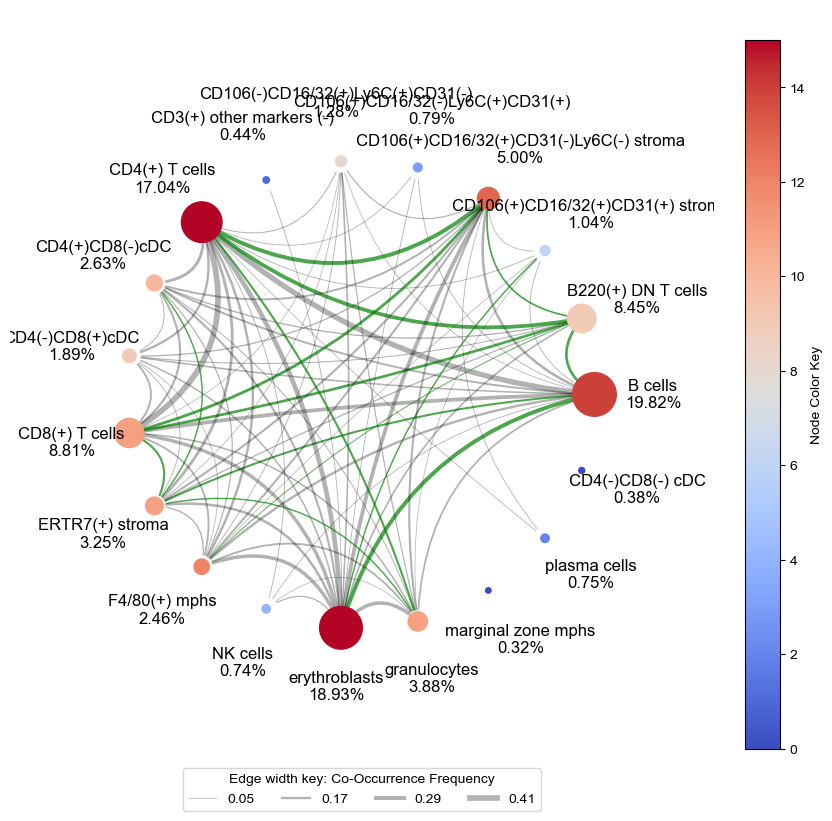

In [22]:
patient_group = 'MRL'
eco.create_circos_plot(circoplot_df1.loc[[patient_group]], 
                       cell_type_colors_hex=None,
                       cell_abundance=circoplot_df2.loc[[patient_group]],
                       threshold=0.05, 
                       edge_weights_scaler=10,
                       highlighted_edges=highlighted_comb,
                       node_weights_scaler=5000,
                       figure_size=(8,8),
                       save_path=None)